# Mask Detection Project

### # import the necessary packages

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

lr: learning rate
bs: batch size 

In [122]:
INIT_LR = 1e-4
EPOCHS = 2
BS = 3

In [231]:
DIRECTORY = r"C:\Users\gokcedeliorman\Desktop\github_mask\dataset"
CATEGORIES = ["with_mask", "without_mask"]
##DIRECTORY2 = r"C:\Users\gokcedeliorman\Desktop\github_mask\data"

data = []
labels = []

In [232]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

C:\Users\gokcedeliorman\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [233]:
print(data.shape)
labels .shape

(3833, 224, 224, 3)


(3833, 2)

In [234]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [126]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=2)

In [127]:
print(labels.shape)
print(trainX.shape)
print(trainY.shape)

(3833, 2)
(3066, 224, 224, 3)
(3066, 2)


In [128]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [129]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [130]:
headModel = baseModel.output

In [131]:
headModel

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

In [132]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

##1, activation='sigmoid'

In [133]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [134]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [135]:
print(baseModel.input)
headModel

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")


<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_9')>

In [119]:
print(trainX.shape)
print(testX.shape)

print(testY.shape)
print(trainY.shape)

(3066, 224, 224, 3)
(767, 224, 224, 3)
(1534, 1)
(6132, 1)


In [109]:
#trainY=trainY.reshape(6132,1)
#testY=testY.reshape(1534,1)

In [136]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/2
1022/1022 [==============================] - 168s 155ms/step - loss: 0.3811 - accuracy: 0.8517 - val_loss: 0.0700 - val_accuracy: 0.9765
Epoch 2/2
1022/1022 [==============================] - 131s 128ms/step - loss: 0.0791 - accuracy: 0.9749


In [137]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)

predIdxs

array([[3.3099222e-05, 9.9996686e-01],
       [2.5744865e-07, 9.9999976e-01],
       [1.2685782e-02, 9.8731428e-01],
       ...,
       [1.0000000e+00, 3.1581248e-08],
       [9.9992239e-01, 7.7576347e-05],
       [3.7457346e-05, 9.9996257e-01]], dtype=float32)

In [140]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
#print(predIdxs)
#predIdxs.shape

In [141]:
predIdxs

array([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,

In [142]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.97      0.99      0.98       383
without_mask       0.99      0.97      0.98       384

    accuracy                           0.98       767
   macro avg       0.98      0.98      0.98       767
weighted avg       0.98      0.98      0.98       767



### Estimation of the photo taken from the data set

In [145]:
import cv2 as cv

In [219]:
Y = []
Y

[]

In [235]:
yol = "C:\\Users\\gokcedeliorman\\Desktop\\github_mask\\dataset\\with_mask\\0_0_4 copy 15.jpg"

In [220]:
yol = "C:\\Users\\gokcedeliorman\\Desktop\\github_mask\\dataset\\without_mask\\0_0_anhu_0027.jpg"

In [204]:
yol = "C:\\Users\\gokcedeliorman\\Desktop\\230121_1988554107521_7175482_n.jpg"

In [243]:
X = cv.imread(yol, 1)
X = cv.resize(X, (224,224))
#Y.append(X)
Y=np.array([X]).astype("float32") / 255.0

In [245]:
def deney(yol):
    X = cv.imread(yol, 1)
    X = cv.resize(X, (224,224))

    return np.array([X]).astype("float32") / 255.0

In [246]:
deney("C:\\Users\\gokcedeliorman\\Desktop\\github_mask\\dataset\\with_mask\\0_0_4 copy 15.jpg")

array([[[[0.92941177, 0.84313726, 0.79607844],
         [0.92941177, 0.84313726, 0.79607844],
         [0.93333334, 0.84313726, 0.79607844],
         ...,
         [0.98039216, 0.94509804, 0.9372549 ],
         [0.96862745, 0.93333334, 0.92156863],
         [0.96862745, 0.93333334, 0.92156863]],

        [[0.93333334, 0.84705883, 0.8       ],
         [0.93333334, 0.84313726, 0.8       ],
         [0.93333334, 0.8392157 , 0.7921569 ],
         ...,
         [0.9764706 , 0.94509804, 0.9372549 ],
         [0.9647059 , 0.92941177, 0.91764706],
         [0.9647059 , 0.92941177, 0.91764706]],

        [[0.9490196 , 0.8509804 , 0.8039216 ],
         [0.9490196 , 0.8509804 , 0.8039216 ],
         [0.93333334, 0.8352941 , 0.7882353 ],
         ...,
         [0.972549  , 0.94509804, 0.93333334],
         [0.9607843 , 0.9254902 , 0.9137255 ],
         [0.9607843 , 0.9254902 , 0.9137255 ]],

        ...,

        [[0.08235294, 0.08627451, 0.08627451],
         [0.08235294, 0.08627451, 0.08627451]

In [224]:
Y = Y.astype("float32") / 255.0
Y

array([[[[0.29411766, 0.03137255, 0.05882353],
         [0.2901961 , 0.02745098, 0.05490196],
         [0.2901961 , 0.02745098, 0.05882353],
         ...,
         [0.9372549 , 0.8       , 0.84313726],
         [0.9843137 , 0.85882354, 0.8980392 ],
         [1.        , 0.88235295, 0.91764706]],

        [[0.3019608 , 0.03921569, 0.06666667],
         [0.29803923, 0.03529412, 0.06666667],
         [0.29803923, 0.03529412, 0.06666667],
         ...,
         [0.90588236, 0.77254903, 0.8117647 ],
         [0.96862745, 0.8392157 , 0.8784314 ],
         [0.99607843, 0.8745098 , 0.9098039 ]],

        [[0.30980393, 0.04313726, 0.07450981],
         [0.30588236, 0.04313726, 0.07450981],
         [0.30588236, 0.03921569, 0.07843138],
         ...,
         [0.85882354, 0.7254902 , 0.7647059 ],
         [0.9372549 , 0.8117647 , 0.84705883],
         [0.9843137 , 0.8627451 , 0.8980392 ]],

        ...,

        [[0.92941177, 0.9098039 , 0.9137255 ],
         [0.92941177, 0.9098039 , 0.91764706]

In [249]:
model.predict(deney("C:\\Users\\gokcedeliorman\\Desktop\\github_mask\\dataset\\with_mask\\0_0_4 copy 15.jpg")) # Tahmin

array([[9.999999e-01, 1.398550e-07]], dtype=float32)

In [239]:
model

##glob: bak!!

In [240]:
predictions

array([[4.1717519e-07, 9.9999964e-01]], dtype=float32)

In [241]:
_, train_acc = model.evaluate(trainX, trainY, verbose=0)
_, test_acc = model.evaluate(testX, testY, verbose=0)

In [242]:
sonuc = predictions.argmax(axis=1)
print(sonuc)

[1]


withoutmask


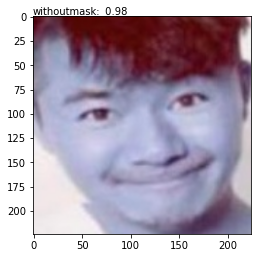

In [230]:
if sonuc== 0:
    print("withmask")
    plt.text(-1, -2, 'withmask:')
    plt.text(60, -2, ' %.2f' % test_acc)
if sonuc == 1:
    print("withoutmask")
    plt.text(-1, -2, 'withoutmask:')
    plt.text(70, -2, ' %.2f' % test_acc)
plt.imshow(X)
plt.show()

In [214]:
predictions

array([[0.98906577, 0.01093428]], dtype=float32)

In [215]:
_, train_acc

(0.04516030102968216, 0.9882583022117615)

In [191]:
_, test_acc 

(0.04516030102968216, 0.9843546152114868)

In [192]:
train_acc = model.evaluate(trainX, trainY, verbose=0)

In [193]:
train_acc

[0.037941887974739075, 0.9882583022117615]

In [194]:
Y

array([[[[0.29411766, 0.03137255, 0.05882353],
         [0.2901961 , 0.02745098, 0.05490196],
         [0.2901961 , 0.02745098, 0.05882353],
         ...,
         [0.9372549 , 0.8       , 0.84313726],
         [0.9843137 , 0.85882354, 0.8980392 ],
         [1.        , 0.88235295, 0.91764706]],

        [[0.3019608 , 0.03921569, 0.06666667],
         [0.29803923, 0.03529412, 0.06666667],
         [0.29803923, 0.03529412, 0.06666667],
         ...,
         [0.90588236, 0.77254903, 0.8117647 ],
         [0.96862745, 0.8392157 , 0.8784314 ],
         [0.99607843, 0.8745098 , 0.9098039 ]],

        [[0.30980393, 0.04313726, 0.07450981],
         [0.30588236, 0.04313726, 0.07450981],
         [0.30588236, 0.03921569, 0.07843138],
         ...,
         [0.85882354, 0.7254902 , 0.7647059 ],
         [0.9372549 , 0.8117647 , 0.84705883],
         [0.9843137 , 0.8627451 , 0.8980392 ]],

        ...,

        [[0.92941177, 0.9098039 , 0.9137255 ],
         [0.92941177, 0.9098039 , 0.91764706]